In [ ]:
#******************************************************************************************************** *#
# Implementation of a Variational Quantum Classifier (VQC) to replicate the parity function.
#******************************************************************************************************** *#

#******************************************************************************************************** *#
# This implementation is based on the following Pennylane tutorial:
# https://pennylane.ai/qml/demos/tutorial_variational_classifier
# Author: Maria Schuld
#******************************************************************************************************** *#
#
#******************************************************************************************************** *#
# Code modified by Prof. Gustavo Patino
# adolfo.patino@udea.edu.co
#******************************************************************************************************** *#

In [2]:
%matplotlib inline

Variational classifier
=================

In this tutorial, we show how to use PennyLane to implement variational
quantum classifiers - quantum circuits that can be trained from labelled
data to classify new data samples. The architecture is inspired by
[Farhi and Neven (2018)](https://arxiv.org/abs/1802.06002) as well as
[Schuld et al. (2018)](https://arxiv.org/abs/1804.00633).


We will first show that the variational quantum classifier can reproduce
the parity function

$$\begin{aligned}
f: x \in \{0,1\}^{\otimes n} \rightarrow y =
\begin{cases} 1 \text{  if uneven number of ones in } x \\ 0
\text{ otherwise} \end{cases}.
\end{aligned}$$

This optimization example demonstrates how to encode binary inputs into
the initial state of the variational circuit, which is simply a
computational basis state.

We then show how to encode real vectors as amplitude vectors (*amplitude
encoding*) and train the model to recognize the first two classes of
flowers in the Iris dataset.

Fitting the parity function
=====================

## 1. Imports


As before, we import PennyLane, the PennyLane-provided version of NumPy,
and an optimizer.


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

## 2. Data Loading and Pre-Processing:


Let's now load and preprocess some data.

The parity dataset can be downloaded [here](https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/parity.txt) and should be placed in the subfolder `data`.

In [4]:
data = np.loadtxt("data/parity.txt")

In [5]:
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

In [6]:
for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


We initialize the variables randomly (but fix a seed for
reproducibility). The first variable in the list is used as a bias,
while the rest is fed into the gates of the variational circuit.

In [7]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [8]:
print(weights_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]


In [9]:
print(bias_init)

0.0


## 3. Quantum nodes

We create a quantum device with four "wires" (or qubits) based on the **qiskit aer** simulator.


In [10]:
#dev = qml.device("default.qubit", wires=4)

In [11]:
import qiskit
dev = qml.device("qiskit.aer", wires=4)

We need a way to encode data inputs $x$ into the circuit, so that
the measured output depends on the inputs. In this first example, the
inputs are bitstrings, which we encode into the state of the qubits. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

We use the [BasisState](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisState.html#pennylane.BasisState) function provided by PennyLane, which expects `x` to be a list of zeros and ones, i.e. `[0,1,0,1]`.


In [12]:
def FeatureMap(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit (also called the **Ansatz Circuit**).

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [13]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0]) 

In [14]:
def Ansatz(weights):
    for W in weights:
        layer(W)   

Now we define the quantum node as a state preparation routine, followed
by a repetition of the layer structure. Borrowing from machine learning,
we call the parameters `weights`.


In [15]:
@qml.qnode(dev)
def circuit(weights, x):

    FeatureMap(x)
    Ansatz(weights)

    return qml.expval(qml.PauliZ(0))

Different from previous examples, the quantum node takes the data as a
keyword argument `x` (with the default value `None`). Keyword arguments
of a quantum node are considered as fixed when calculating a gradient;
they are never trained.

If we want to add a "classical" bias parameter, the variational quantum
classifier also needs some post-processing. We define the final model by
a classical node that uses the first variable, and feeds the remainder
into the quantum node. Before this, we reshape the list of remaining
variables for easy use in the quantum node.


In [16]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [17]:
weights = weights_init
x = X[1]

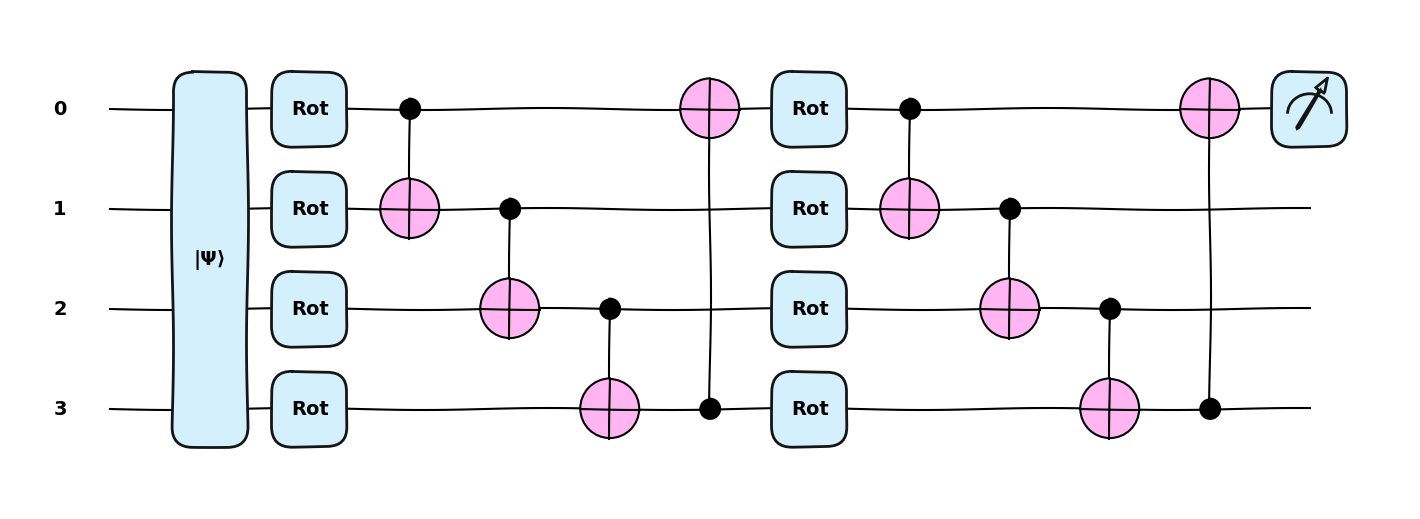

In [18]:
# Quantum circuit represented by Pennylane
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(circuit)(weights, x) # parameters given to the quantum circuit

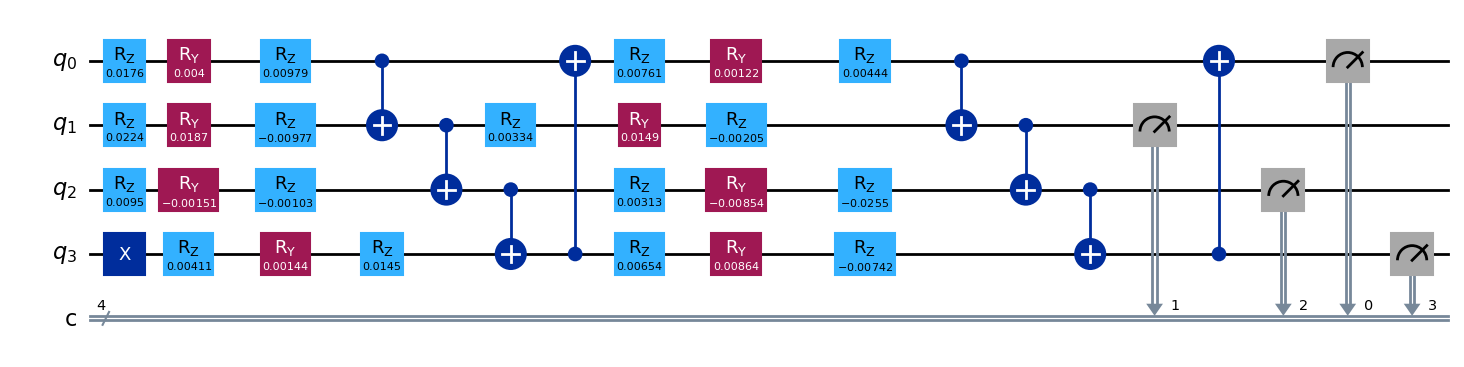

In [19]:
circuit(weights, x)
# Quantum circuit represented by Qiskit
dev._circuit.draw(output="mpl", style="iqp")


Post-Processing:
-----------------------
## 4. Cost

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We use the standard square loss that
measures the distance between target labels and model predictions.


In [20]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy given target labels and model predictions.


In [21]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [22]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Post-Processing:
-----------------------
## 5. Optimization


Next we create an optimizer and choose a batch size...


In [23]:
# Selection and configuration of the Optimizer
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

...and train the optimizer. We track the accuracy - the share of
correctly classified data samples. For this we compute the outputs of
the variational classifier and turn them into predictions in $\{-1,1\}$
by taking the sign of the output.


In [24]:
weights = weights_init
print("The initial weights are\n\n", weights)
print(' ')

The initial weights are

 [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
 


In [25]:
bias = bias_init
num_it = 25    # Number of iterations

In [26]:
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    
    #print("The random batch indexes to use in the training are:", batch_index)
    #print(' ')
    
    X_batch = X[batch_index]
    #print("The X subset selected randomly by the batch index is:", X_batch)
    #print(' ')
    Y_batch = Y[batch_index]
    #print("The Y subset selected randomly by the batch index is:", Y_batch)
    #print(' ')
    
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

Iter:     1 | Cost: 3.4347708 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.9280074 | Accuracy: 0.5000000 
Iter:     3 | Cost: 1.6540481 | Accuracy: 0.5000000 
Iter:     4 | Cost: 1.3278412 | Accuracy: 0.5000000 
Iter:     5 | Cost: 1.0562729 | Accuracy: 0.5625000 
Iter:     6 | Cost: 0.9722697 | Accuracy: 0.5000000 
Iter:     7 | Cost: 0.1624964 | Accuracy: 1.0000000 
Iter:     8 | Cost: 0.1069174 | Accuracy: 1.0000000 
Iter:     9 | Cost: 0.3676175 | Accuracy: 1.0000000 
Iter:    10 | Cost: 0.3889947 | Accuracy: 0.8125000 
Iter:    11 | Cost: 0.1209916 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.0453670 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.0368379 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.0363370 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0546157 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.0205355 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.0064892 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.0018407 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.0007402 | Accuracy: 1.00

In [27]:
print("The final weights after training are\n\n", weights)

The final weights after training are

 [[[ 2.35635460e-01  1.63398988e+00  6.46585479e-02]
  [ 6.12528709e-01  1.68346899e+00 -1.87639249e-04]
  [ 2.54980990e-01 -1.14361805e-01  5.88452726e-01]
  [ 1.22186002e-01  1.68582938e+00  9.36301023e-03]]

 [[ 1.40682135e-01 -9.18880186e-03 -1.46575732e-01]
  [ 1.10425819e+00 -1.98124226e-01 -2.28199765e-03]
  [-9.61846253e-01 -5.03724350e-02 -2.06824451e-02]
  [ 2.99005941e-02  1.67938048e+00 -8.42554909e-02]]]


## Platform and Tool Versions

In [28]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['Python-version']=platform.python_version()
        info['Pennylane-version']=info['Pennylane-version']=qml.version()
        info['Qiskit-version']=qiskit.__version__
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'platform': 'Windows',
 'platform-release': '10',
 'platform-version': '10.0.19045',
 'Python-version': '3.11.4',
 'Pennylane-version': '0.33.1',
 'Qiskit-version': '0.45.0',
 'architecture': 'AMD64',
 'hostname': 'DESKTOP-RRB2H12',
 'ip-address': '192.168.1.145',
 'mac-address': 'f0:1f:af:32:d1:ee',
 'processor': 'Intel64 Family 6 Model 58 Stepping 9, GenuineIntel',
 'ram': '16 GB'}